In [1]:
# import abc
from abc import ABC, abstractmethod
from collections import OrderedDict
import random
import pandas as pd

color_dict = {
    'Red': '\x1b[31m',
    'Green': '\x1b[32m',
    'White': '\x1b[37m',
    'Orange': '\x1b[33m',
    'Blue': '\x1b[34m',
    'Purple': '\x1b[35m',
    'Black': '\x1b[30m',
    'Yellow': '\x1b[33m',
    'Turquoise': '\x1b[36m',
}

/tmp/ipykernel_575531/3225086116.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class Sack:
    def __init__(self):
        self.chips = [KnallChip(1)]*4 + [KnallChip(2)]*2 + [KnallChip(3)]*1+ [OrangeChip(1)]*1 + [GreenChip(1)]*1

    def ziehen(self):
        index = random.randint(0,len(self.chips)-1)
        return self.chips.pop(index)

    def stopfen(self, chip):
        self.chips.append(chip)

moneros = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,15,16,16,17,17,18,18,19,19,20,20,21,21,22,22,23,23,24,24,25,25,26,26,27,27,28,28,29,29,30,30,31,31,32,32,33,33]
rubinis = [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
siegis =  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9,10,10,10,11,11,11,12,12,12,12,13,13,13,14,14]
print(len(moneros))
print(len(rubinis))

class Player():
    def __init__(self, name):
        self.name = name
        self.sack = Sack()
        self.kessel = Kessel(self.sack)

        self.siegis = 0
        self.rubinis = 0
        self.moneros = 0

    def stop_condition(self):
        return not self.kessel.exploded

    def runde(self):
        while self.stop_condition():
            self.kessel.brauen()

        earned_siegis, earned_moneros, earned_rubinis = self.kessel.wertung()

        self.siegis += earned_siegis
        self.moneros += earned_moneros
        self.rubinis += earned_rubinis



        # TODO: implement using moneros to buy chips
        assert self.moneros >= 3, "Not enough moneros to buy a this strategy"

        if self.moneros - OrangeChip(1).cost >= 16:
            self.sack.chips.append(RedChip(4))
            self.sack.chips.append(OrangeChip(1))
        elif self.moneros - OrangeChip(1).cost >= 10:
            self.sack.chips.append(RedChip(2))
            self.sack.chips.append(OrangeChip(1))
        elif self.moneros - OrangeChip(1).cost >= 6:
            self.sack.chips.append(RedChip(1))
            self.sack.chips.append(OrangeChip(1))
        elif self.moneros - OrangeChip(1).cost >= 3:
            self.sack.chips.append(RedChip(1))


        # Prepare for next round
        for chip in self.kessel.values():
            self.sack.stopfen(chip)

        self.moneros = 0
        self.kessel.clear()

        self.kessel.exploded = False

class Schisser(Player):
    def stop_condition(self):
        return max([chip.value for chip in self.sack.chips if isinstance(chip, KnallChip)]) + self.kessel.getSumOfKind(KnallChip) < self.kessel.explosion_threshold

class Kessel(OrderedDict):
    def __init__(self, sack:Sack) -> None:
        self.sack = sack
        self.exploded = False
        self.explosion_threshold = 8

    def brauen(self):
        chip = self.sack.ziehen()
        chip.played(self)
        # TODO: check if previous board modifies position further (in a way not specific to chip)

        if chip.knallerbse:
            if self.getSumOfKind(KnallChip) >= self.explosion_threshold:
                #print("BOOM")
                self.exploded = True

    def wertung(self):
        # TODO: implement getting rubins for green chip at last 2 spots
        #print(green_in_last_two, [chip for chip in list(self.values())[-2:]])

        # TODO: implement getting siegis/rubins/drops for purple

        eval_number = self.getCurrenPosition()+1
        if eval_number >= len(siegis):
            eval_number = len(siegis)-1

        earned_siegis  = siegis[eval_number]
        earned_moneros = moneros[eval_number]
        earned_rubinis = rubinis[eval_number]

        green_in_last_two = [chip for chip in list(self.values())[-2:] if isinstance(chip, GreenChip)]
        if len(green_in_last_two) > 0:
            earned_rubinis += 1

        return earned_siegis, earned_moneros, earned_rubinis

    def getCurrenPosition(self):
        if len(self) == 0:
            return 0
        return next(reversed(self))

    def getNumberOfKind(self, kind):
        return len([x for x in self.values() if isinstance(x, kind)])

    def getSumOfKind(self, kind):
        return sum([x.value for x in self.values() if isinstance(x, kind)])

class Chip:
    def __init__(self, value, knallerbse=False):
        self.value = value
        self.knallerbse = knallerbse
        self.color = "\x1b[37m"

    def __repr__(self) -> str:
        return f'{self.color}███\x1b[0m {self.value}'
        # return str(self.__class__.__name__) + "(" +str(self.value)+")"

    def played(self, kessel:Kessel):
        position = kessel.getCurrenPosition() + self.value
        kessel[position] = self

class RedChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  6),
                                (2, 10),
                                (4, 16)])
        self.cost = costs[value]
        self.color = color_dict['Red']

    def played(self, kessel:Kessel):
        additional = 0
        n_orange = kessel.getNumberOfKind(OrangeChip)
        if n_orange > 0:
            additional = 1
        elif n_orange > 2:
            additional = 2
        position = kessel.getCurrenPosition() + self.value + additional
        kessel[position] = self

class OrangeChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  3),])
        self.cost = costs[value]
        self.color = color_dict['Orange']

class GreenChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  4),
                                (2,  8),
                                (4, 14)])
        self.cost = costs[value]
        self.color = color_dict['Green']

class YellowChip(Chip):
    def __init__(self, value, knallerbse=False):
        super().__init__(value, knallerbse)

        costs = OrderedDict([   (1,  8),
                                (2, 12),
                                (4, 18)])
        self.cost = costs[value]
        self.color = color_dict['Yellow']

    def played(self, kessel: Kessel):
        super().played(kessel)
        if isinstance(kessel[kessel.getCurrenPosition()], KnallChip):
            del kessel[kessel.getCurrenPosition()]

class BlueChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  5),
                                (2, 10),
                                (4, 19)])
        self.cost = costs[value]
        self.color = color_dict['Blue']

    def played(self, kessel: Kessel):
        super().played(kessel)

        options = [kessel.sack.ziehen() for i in range(self.value)]
        choice_index = int(input("Choose one of the following chips by index: " + str(options)))

        if choice_index == -1:                      # choose not to play anything
            pass
        elif choice_index >= 0 and choice_index < len(options):
            options[choice_index].played(kessel)    # play the chip
            del options[choice_index]               # remove the chip from the options
        else:
            raise ValueError("Invalid choice")
        for option in options:
            kessel.sack.stopfen(option)

class PurpleChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([(1,  9)])
        self.cost = costs[value]
        self.color = color_dict['Purple']

class KnallChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=True)
        self.color = color_dict['White']

    def played(self, kessel:Kessel):
        return super().played(kessel)


initial_content = [KnallChip(1)]*4 + [KnallChip(2)]*2 + [KnallChip(3)]*1+ [OrangeChip(1)]*1 + [GreenChip(1)]*1

p1 = Player("Player1")

for i in range(3):
    p1.kessel.brauen()
    print(p1.kessel)

p1.sack.chips.append(YellowChip(1))
print('added yellow chip in sack')

p1.sack.chips.append(RedChip(1))
print('added red chip in sack')

#sack1.chips.append(BlueChip(1))
#print('added blue chip in sack')

for i in range(6):
    p1.kessel.brauen()
    print(p1.kessel)

print(p1.kessel)

53
53
Kessel([(1, ███ 1)])
Kessel([(1, ███ 1), (3, ███ 2)])
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2)])
added yellow chip in sack
added red chip in sack
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2), (6, ███ 1)])
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2), (6, ███ 1), (7, ███ 1)])
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2), (6, ███ 1), (7, ███ 1), (8, ███ 1)])
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2), (6, ███ 1), (7, ███ 1), (8, ███ 1), (9, ███ 1)])
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2), (6, ███ 1), (7, ███ 1), (8, ███ 1), (9, ███ 1), (10, ███ 1)])
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2), (6, ███ 1), (7, ███ 1), (8, ███ 1), (9, ███ 1), (10, ███ 1), (11, ███ 1)])
Kessel([(1, ███ 1), (3, ███ 2), (5, ███ 2), (6, ███ 1), (7, ███ 1), (8, ███ 1), (9, ███ 1), (10, ███ 1), (11, ███ 1)])


In [3]:
example_ordered_dict = OrderedDict([(1, 1), (2, 2), (3, 3)])
example_ordered_dict[6] = 4
example_ordered_dict.clear()
example_ordered_dict

OrderedDict()

<Axes: title={'center': 'Strategy: Pyrotechnician-isst-Kürbis-Pilssuppe'}, ylabel='Frequency'>

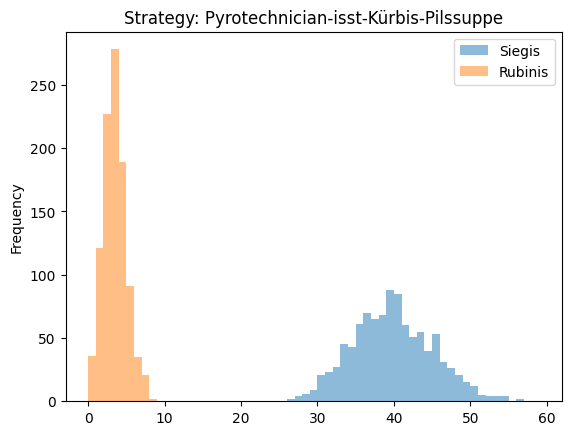

In [4]:
n_simulations = 1000
n_rounds = 9

wertungen = []

strategy_name = "Pyrotechnician-isst-Kürbis-Pilssuppe"

for i in range(n_simulations):

    player = Player(strategy_name + "_" + str(i))

    for j in range(n_rounds):
        player.runde()

        wertungen.append([i, j, player.siegis, player.moneros, player.rubinis])

wertungen = pd.DataFrame(wertungen, columns=["Simulation", "Round", "Siegis", "Moneros", "Rubinis"])

wertungen[wertungen['Round'] == n_rounds-1][['Siegis', 'Rubinis']].plot.hist(bins=range(0, 60), alpha=0.5, title="Strategy: " + strategy_name )


In [5]:
player.sack.chips

[███ 1,
 ███ 1,
 ███ 1,
 ███ 4,
 ███ 1,
 ███ 2,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 2,
 ███ 1,
 ███ 1,
 ███ 4,
 ███ 1,
 ███ 1,
 ███ 2,
 ███ 2,
 ███ 4,
 ███ 2,
 ███ 1,
 ███ 1,
 ███ 4,
 ███ 3]

<Axes: title={'center': 'Strategy: Schisser-isst-Kürbis-Pilssuppe'}, ylabel='Frequency'>

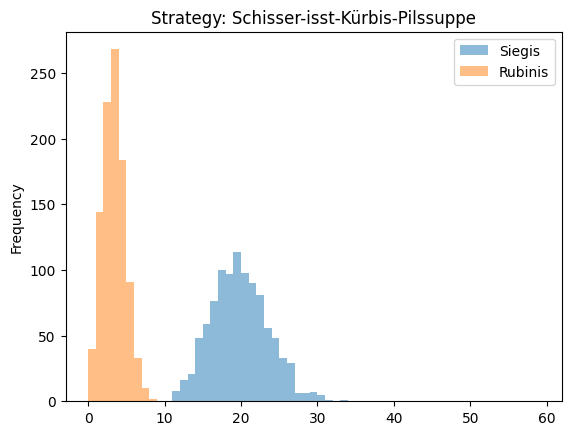

In [6]:
n_simulations = 1000
n_rounds = 9

wertungen = []

strategy_name = "Schisser-isst-Kürbis-Pilssuppe"

for i in range(n_simulations):

    player = Schisser(strategy_name + "_" + str(i))

    for j in range(n_rounds):
        player.runde()

        wertungen.append([i, j, player.siegis, player.moneros, player.rubinis])

wertungen = pd.DataFrame(wertungen, columns=["Simulation", "Round", "Siegis", "Moneros", "Rubinis"])

wertungen[wertungen['Round'] == n_rounds-1][['Siegis', 'Rubinis']].plot.hist(bins=range(0, 60), alpha=0.5, title="Strategy: " + strategy_name )


In [7]:
player.sack.chips

[███ 1,
 ███ 1,
 ███ 2,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 2,
 ███ 1,
 ███ 3,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 2,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 1,
 ███ 2]

In [8]:
wertungen

,Simulation,Round,Siegis,Moneros,Rubinis
0,0,0,1,0,0
1,0,1,2,0,0
2,0,2,3,0,0
3,0,3,4,0,0
4,0,4,6,0,1
...,...,...,...,...,...
8995,999,4,6,0,1
8996,999,5,8,0,1
8997,999,6,9,0,3
8998,999,7,12,0,4


In [10]:
# n_simulations = 10

# wertungen = []

# for i in range(n_simulations):

#     player = Player(strategy_name + "_" + str(i))






# wertungen = pd.DataFrame(wertungen, columns=["Siegis", "Moneros", "Rubinis"])

# wertungen.plot.hist(bins=range(0, 20), alpha=0.5, title="Strategy: Schisser")


In [11]:
# n_simulations = 10000

# wertungen = []

# for i in range(n_simulations):
#     initial_content = [KnallChip(1)]*4 + [KnallChip(2)]*2 + [KnallChip(3)]*1+ [OrangeChip(1)]*1 + [GreenChip(1)]*1
#     sack = Sack(initial_content)
#     kessel = Kessel(sack)


#     while max([chip.value for chip in sack.chips if isinstance(chip, KnallChip)]) + kessel.getSumOfKind(KnallChip) < kessel.explosion_threshold:
#         kessel.brauen()

#     kessel.wertung()

#     #print(f"Simulation {i+1}: {kessel.siegis} Siegis, {kessel.moneros} Moneros, {kessel.rubinis} Rubinis")
#     wertungen.append([kessel.siegis, kessel.moneros, kessel.rubinis])

# wertungen = pd.DataFrame(wertungen, columns=["Siegis", "Moneros", "Rubinis"])

# wertungen.plot.hist(bins=range(0, 20), alpha=0.5, title="Strategy: Schisser")


In [12]:
# n_simulations = 10
# n_rounds = 2

# wertungen = []

# for i in range(n_simulations):

#     player = Player(strategy_name + "_" + str(i))


#     for i in range(n_rounds):

#         player.runde()



# wertungen = pd.DataFrame(wertungen, columns=["Siegis", "Moneros", "Rubinis"])

# wertungen.plot.hist(bins=range(0, 20), alpha=0.5, title="Strategy: Schisser")


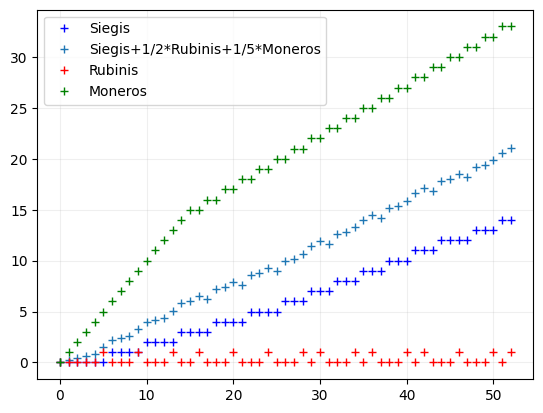

In [23]:
# just plot siegis rubinis and moneros for each field
import matplotlib.pyplot as plt
import numpy as np
plt.plot(siegis, "+", label="Siegis", color="blue")
siegies = np.array(siegis)
rubinis = np.array(rubinis)
moneros = np.array(moneros)
plt.plot(siegis+rubinis*0.5+moneros*0.2, "+", label="Siegis+1/2*Rubinis+1/5*Moneros")
plt.plot(rubinis, "+", label="Rubinis", color="red")
plt.plot(moneros, "+", label="Moneros", color="green")
plt.legend()
plt.grid(alpha=0.2)